## Importing the Data

In [1]:
# Constants
DATASET_DIR = './kaggle-dataset/'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])

In [2]:
X.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


Minimum and Maximum Scores for each essay set.

In [3]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

## Preprocessing the Data

We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [4]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

## Defining the model 

Here we define a 2-Layer LSTM Model. 


In [5]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

C:\Users\PARIDHI\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Training Phase

Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold.
We will then calculate Average Kappa for all the folds.

In [6]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

cv = KFold(len(X), n_folds=5, shuffle=True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv:
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
    lstm_model = get_model()
    history = lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=120)
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)
    
    # Save any one of the 8 models.
    if count == 5:
         lstm_model.save('./model_weights/final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1
        

C:\Users\PARIDHI\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



--------Fold 1--------

Training Word2Vec Model...


C:\Users\PARIDHI\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
10380/10380 [==============================] - 10s 998us/step - loss: 64.3894 - mean_absolute_error: 4.3115
Epoch 2/120
10380/10380 [==============================] - 9s 843us/step - loss: 39.4969 - mean_absolute_error: 3.4606
Epoch 3/120
10380/10380 [====

10380/10380 [==============================] - 8s 796us/step - loss: 6.8809 - mean_absolute_error: 1.4263 7s - loss: 2.6649 - mea - ETA: 6s - loss: 5.3058 - mean_absolute_ - ETA: 5s - loss: 5.7706 - mean_absolute_er - ETA: 5s - loss: 5.7510 - mean_abs
Epoch 120/120
10380/10380 [==============================] - 7s 701us/step - loss: 6.9872 - mean_absolute_error: 1.4252
Kappa Score: 0.9620323017556787

--------Fold 2--------

Training Word2Vec Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense) 

10381/10381 [==============================] - 9s 828us/step - loss: 7.0114 - mean_absolute_error: 1.4468
Epoch 119/120
10381/10381 [==============================] - 9s 888us/step - loss: 6.5953 - mean_absolute_error: 1.4279
Epoch 120/120
10381/10381 [==============================] - 9s 850us/step - loss: 6.8354 - mean_absolute_error: 1.4248
Kappa Score: 0.9671342305342847

--------Fold 3--------

Training Word2Vec Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)    

10381/10381 [==============================] - 8s 808us/step - loss: 7.0363 - mean_absolute_error: 1.4364
Epoch 118/120
10381/10381 [==============================] - 8s 747us/step - loss: 7.1247 - mean_absolute_error: 1.4470
Epoch 119/120
10381/10381 [==============================] - 9s 835us/step - loss: 7.2328 - mean_absolute_error: 1.4510
Epoch 120/120
10381/10381 [==============================] - 8s 775us/step - loss: 7.4967 - mean_absolute_error: 1.4533
Kappa Score: 0.9694664048286248

--------Fold 4--------

Training Word2Vec Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)               

10381/10381 [==============================] - 8s 797us/step - loss: 6.5160 - mean_absolute_error: 1.4077
Epoch 114/120
10381/10381 [==============================] - 8s 783us/step - loss: 6.6576 - mean_absolute_error: 1.4215
Epoch 115/120
10381/10381 [==============================] - 9s 830us/step - loss: 6.6325 - mean_absolute_error: 1.4137
Epoch 116/120
10381/10381 [==============================] - 8s 804us/step - loss: 6.8620 - mean_absolute_error: 1.4294
Epoch 117/120
10381/10381 [==============================] - 9s 823us/step - loss: 6.9705 - mean_absolute_error: 1.4471
Epoch 118/120
10381/10381 [==============================] - 8s 810us/step - loss: 6.7003 - mean_absolute_error: 1.4177 2s - l
Epoch 119/120
10381/10381 [==============================] - 8s 819us/step - loss: 6.5456 - mean_absolute_error: 1.4026
Epoch 120/120
10381/10381 [==============================] - 8s 779us/step - loss: 6.5239 - mean_absolute_error: 1.4135
Kappa Score: 0.9607685864369392

--------Fold 5

10381/10381 [==============================] - 8s 791us/step - loss: 7.2001 - mean_absolute_error: 1.4868
Epoch 116/120
10381/10381 [==============================] - 9s 833us/step - loss: 7.3628 - mean_absolute_error: 1.4751
Epoch 117/120
10381/10381 [==============================] - 8s 798us/step - loss: 6.9710 - mean_absolute_error: 1.4515
Epoch 118/120
10381/10381 [==============================] - 8s 795us/step - loss: 7.2170 - mean_absolute_error: 1.4697
Epoch 119/120
10381/10381 [==============================] - 8s 798us/step - loss: 6.9644 - mean_absolute_error: 1.4451
Epoch 120/120
10381/10381 [==============================] - 9s 835us/step - loss: 7.2723 - mean_absolute_error: 1.4719
Kappa Score: 0.9602836463725429


In [10]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.9639


In [8]:
results

[0.9620323017556787,
 0.9671342305342847,
 0.9694664048286248,
 0.9607685864369392,
 0.9602836463725429]

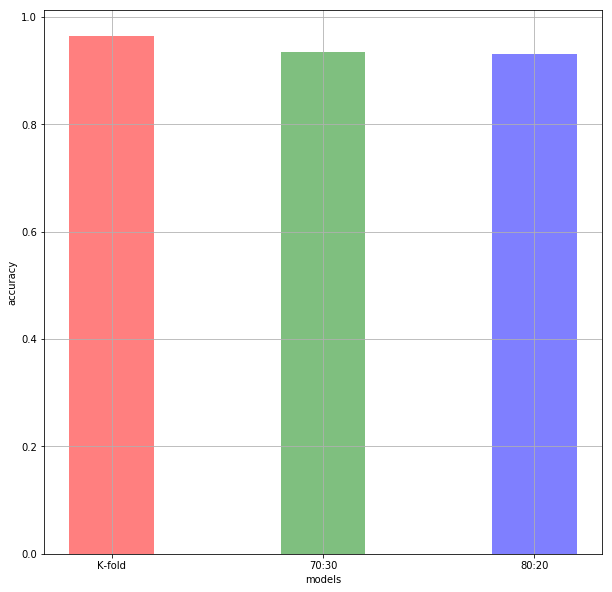

In [12]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(10,10))
lis = [0.9639, 0.9345, 0.9311]
bars = ('K-fold', '70:30', '80:20')
y_pos = np.arange(len(bars))
plt.ylabel("accuracy")
plt.xlabel("models")
plt.bar(bars,lis, width=0.4, alpha=0.5, color=['r','g','b','y'])
plt.grid(True)
plt.show()
